Aquí irá el portafolio de Blumenkron

#Introducción

Los incendios forestales han sido un fenómeno que ha afectado de diversas maneras a las personas al rededor del mundo

In [17]:
import os, shutil, pathlib
from tensorflow import keras #type: ignore
from keras.utils import to_categorical #type: ignore
from keras.utils import image_dataset_from_directory #type: ignore
from keras.models import Sequential #type: ignore
from keras.callbacks import EarlyStopping, ModelCheckpoint #type: ignore
from keras.layers import Dense, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, BatchNormalization, RandomFlip, RandomZoom, RandomRotation, RandomContrast, Rescaling, GlobalMaxPooling2D #type: ignore
from keras.optimizers import Adam #type: ignore
from keras.regularizers import l2 #type: ignore
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class_names = ["Battery","Glass","Metal","Organic","Paper","Plastic"]

base_dir = pathlib.Path("ImagenesOrdenadas")


train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(224, 224),
    batch_size=32,
   label_mode="int",
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="int")

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="int")


Found 3252 files belonging to 6 classes.
Found 696 files belonging to 6 classes.
Found 702 files belonging to 6 classes.


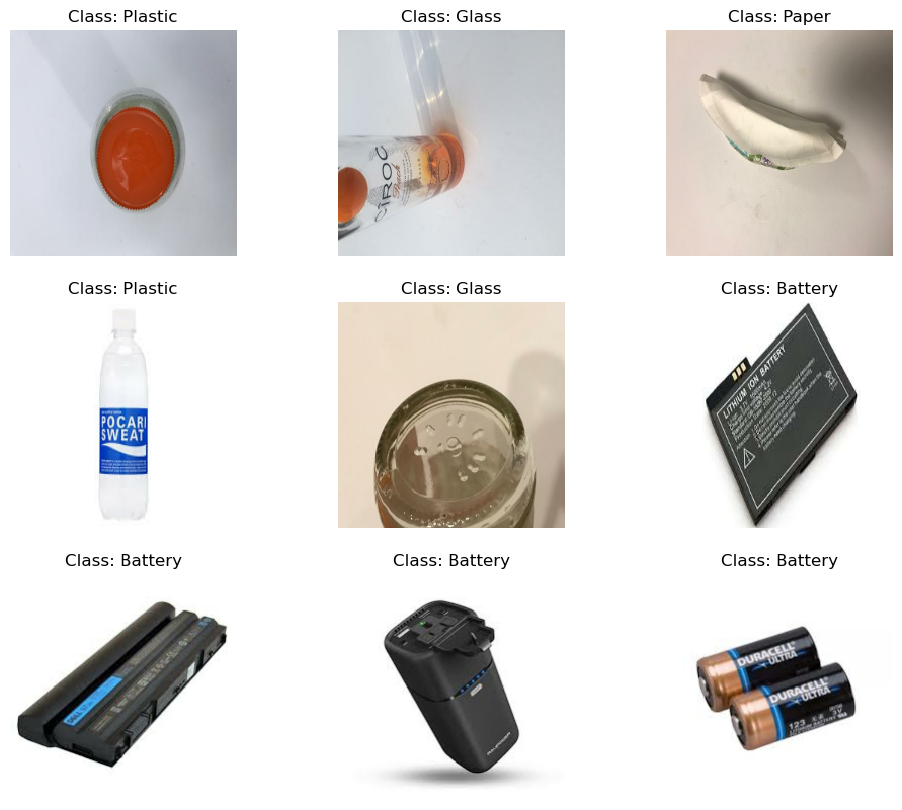

In [8]:
plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

PRIMERO SE HACE LA RESIDUAL UNIT PARA EVITAR EL PROBLEMA DE LA DEGRADACIÓN que ocurre cuando un modelo profundo empeora su rendimiento debido a una pérdida de información en las capas.

In [42]:
class ResidualUnit(keras.layers.Layer): # Extend base Layer class
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs) # Call Layer's init
        self.activation = keras.activations.get(activation) # Get activation layer
        self.main_layers = [
            keras.layers.SeparableConv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.SeparableConv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1: # Resize input if needed
            self.skip_layers = [
                keras.layers.SeparableConv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


In [20]:
def modelo_cnn(input_shape=(224, 224, 3), num_classes=6):
    model = Sequential()

    model.add(RandomFlip("horizontal_and_vertical", input_shape=input_shape))
    model.add(RandomRotation(0.2))
    model.add(RandomZoom(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=3, strides=2, padding="same"))

    model.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=3, strides=2, padding="same"))
    
    prev_filters = 64
    for filters in [64] * 3 + [128] * 4:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    
    # Aplanamiento de las características
    model.add(GlobalAveragePooling2D())

    # Capa completamente conectada
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Capa de salida
    model.add(Dense(num_classes, activation='softmax'))

    return model

modelo = modelo_cnn(input_shape=(224, 224, 3), num_classes=6)
modelo.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_9 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_9 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_9 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_49 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 32)    

In [21]:
modelo.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:

early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=3,          
    restore_best_weights=True  
)

model_checkpoint = ModelCheckpoint(
    'best_model_checkpoint.keras', save_best_only=True, monitor='val_loss'
    )


# Entrenar el modelo
history = modelo.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopper]
)


Epoch 1/20
102/102 [==============================] - 197s 2s/step - loss: 1.6268 - accuracy: 0.3801 - val_loss: 2.4708 - val_accuracy: 0.1710
Epoch 2/20
102/102 [==============================] - 203s 2s/step - loss: 1.4429 - accuracy: 0.4379 - val_loss: 6.8653 - val_accuracy: 0.1940
Epoch 3/20
102/102 [==============================] - 216s 2s/step - loss: 1.3915 - accuracy: 0.4757 - val_loss: 3.2011 - val_accuracy: 0.1796
Epoch 4/20
102/102 [==============================] - 225s 2s/step - loss: 1.3569 - accuracy: 0.4935 - val_loss: 1.5056 - val_accuracy: 0.4210
Epoch 5/20
102/102 [==============================] - 225s 2s/step - loss: 1.3375 - accuracy: 0.4948 - val_loss: 1.3478 - val_accuracy: 0.4871
Epoch 6/20
102/102 [==============================] - 221s 2s/step - loss: 1.3305 - accuracy: 0.5043 - val_loss: 1.8989 - val_accuracy: 0.3922
Epoch 7/20
102/102 [==============================] - 216s 2s/step - loss: 1.3098 - accuracy: 0.5209 - val_loss: 2.2231 - val_accuracy: 0.2586

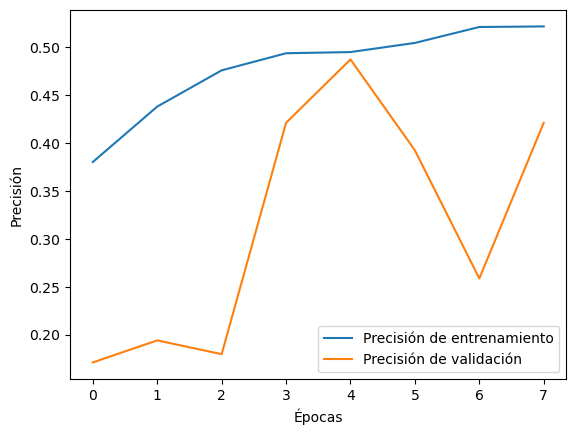

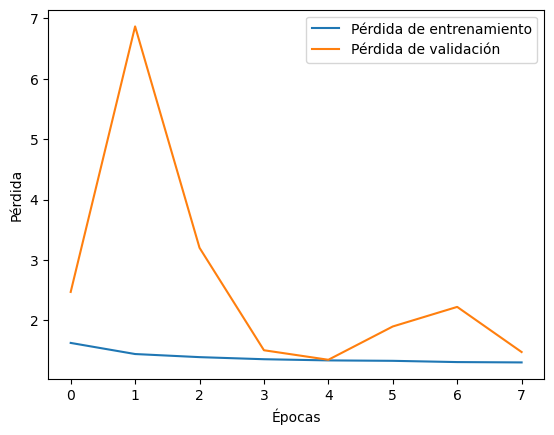

In [23]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [24]:
predictions = modelo.predict(test_dataset)

predicted_classes = predictions.argmax(axis=1)

22/22 [==============================] - 4s 167ms/step


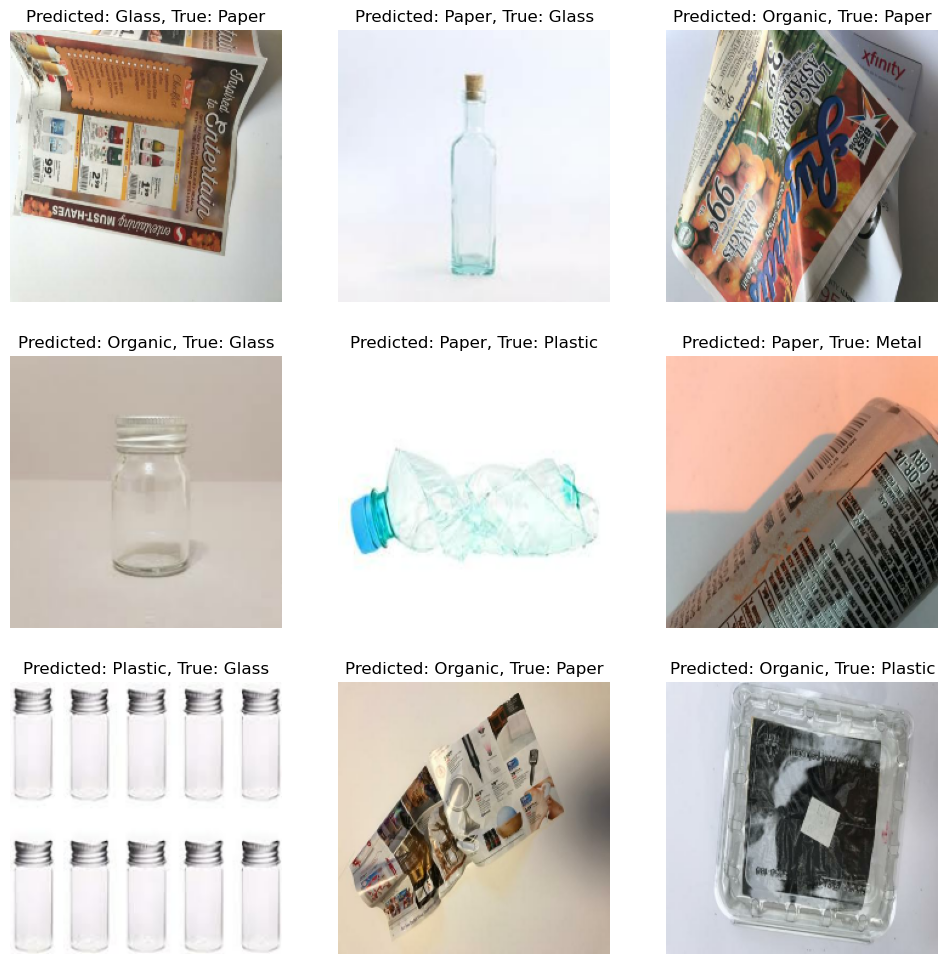

In [25]:
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Cambiar la forma en que se muestra la clase predicha y la verdadera
            plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)

In [26]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modelo.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


22/22 [==============================] - 4s 158ms/step - loss: 1.3371 - accuracy: 0.4915
Test Loss: 1.3371461629867554, Test Accuracy: 0.49145299196243286


Ahora se harán algunas modificaciones al modelo para obtener mejores resultados

-Se le agregaron dos capas convolucionales mas (254,512)
-Ahora la capa Dense tiene 256 neuronas
-Adam con learning rate de 0.0001
-Dropout a 0.7
-Aumentar patience de early 
-Implementación de regularización l2 en capas de conv2d

Opté por mas capas de Rsidual en lugar de L2 regualirization porque esta última es mejor en modelos más simples, pero tareas como desvanecimiento de gradientes o de aprendizaje no las puede abordar eficazmente en redes profundas. Si se utilizaran solo L2, se estaría propiciando a que el modelo aprenda representaciones más superficiales.

In [40]:
def modelo_cnn_mejorado(input_shape=(224, 224, 3), num_classes=6):
    model = Sequential()
    
    model.add(RandomFlip("horizontal_and_vertical",input_shape=input_shape))
    model.add(RandomRotation(0.5))
    model.add(RandomZoom(0.5))
    model.add(RandomContrast(0.5))

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=3, strides=2, padding="same"))

    model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=3, strides=2, padding="same"))
    
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=3, strides=2, padding="same"))

    prev_filters = 128
    for filters in [128] * 4 + [256] * 6 + [512] * 3:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters

    
    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

model_final = modelo_cnn_mejorado(input_shape=(224, 224, 3), num_classes=6)
model_final.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_18 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_18 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_18 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 random_contrast_8 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                                         
                                                                 
 conv2d_46 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_229 (Ba  (None, 224, 224, 32)   

In [41]:
model_final.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[early_stopper,model_checkpoint]
)

Epoch 1/30
102/102 [==============================] - 433s 4s/step - loss: 1.6666 - accuracy: 0.3542 - val_loss: 1.7923 - val_accuracy: 0.1667
Epoch 2/30
102/102 [==============================] - 409s 4s/step - loss: 1.3443 - accuracy: 0.4895 - val_loss: 1.7937 - val_accuracy: 0.1667
Epoch 3/30
102/102 [==============================] - 430s 4s/step - loss: 1.2775 - accuracy: 0.5175 - val_loss: 1.7956 - val_accuracy: 0.1667
Epoch 4/30
102/102 [==============================] - 403s 4s/step - loss: 1.2239 - accuracy: 0.5338 - val_loss: 1.7793 - val_accuracy: 0.1839
Epoch 5/30
102/102 [==============================] - ETA: 0s - loss: 1.1634 - accuracy: 0.5544

NotImplementedError: 
Layer ResidualUnit has arguments ['filters', 'strides', 'activation']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

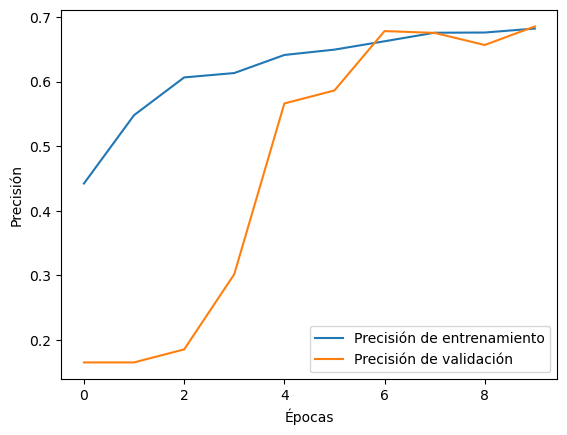

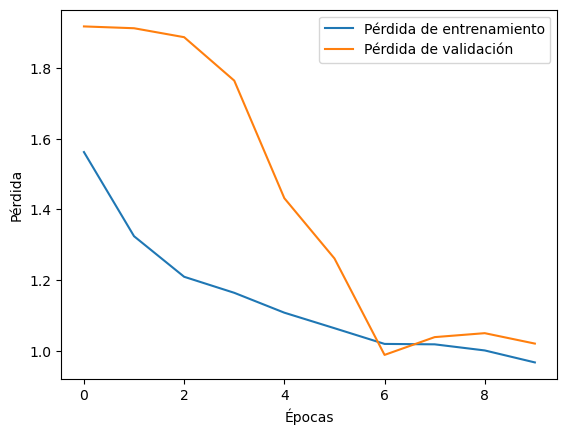

In [ ]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = model_final.predict(test_dataset)

predicted_classes = predictions.argmax(axis=1)

22/22 [==============================] - 4s 154ms/step


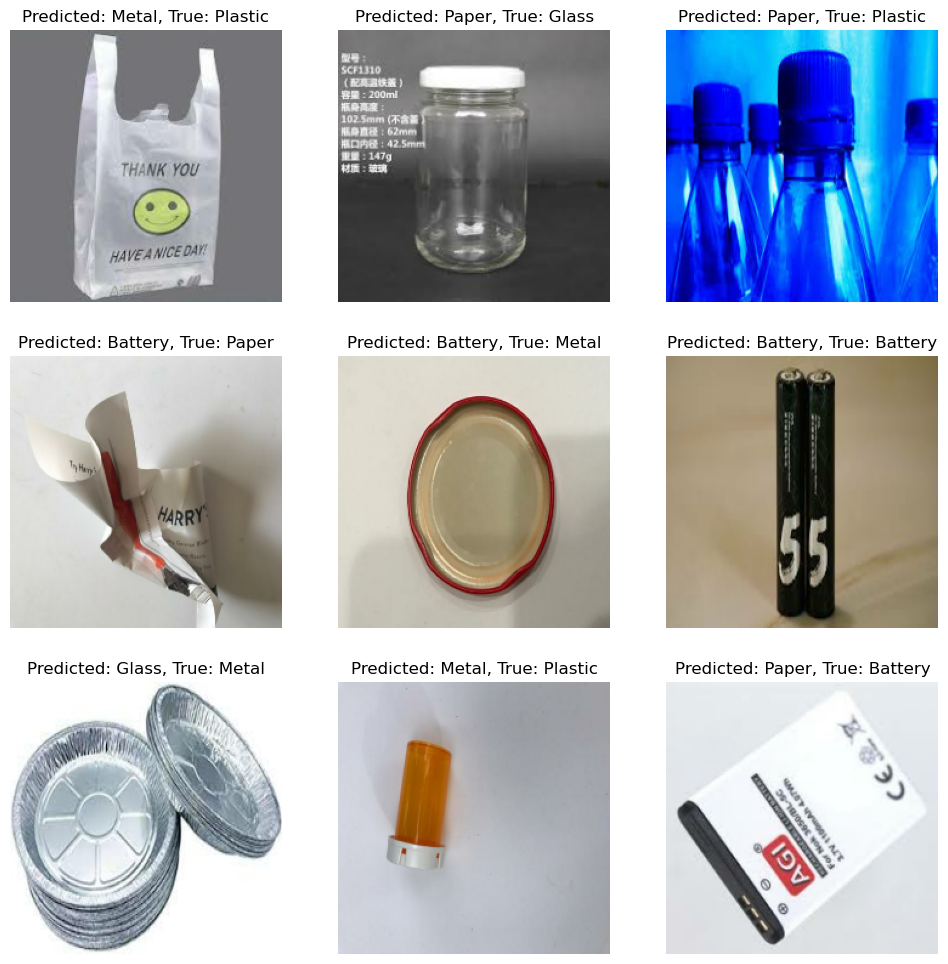

In [ ]:
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Cambiar la forma en que se muestra la clase predicha y la verdadera
            plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)

In [ ]:
test_loss, test_accuracy = model_final.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

22/22 [==============================] - 3s 146ms/step - loss: 0.6644 - accuracy: 0.7764
Test Loss: 0.6643525958061218, Test Accuracy: 0.7763532996177673
